# Insect Recognizer

## Introduction

This notebook is the starting point for insect recognizer.

## Data Importing

In [42]:
# Link for downloaiding the dataset: https://zenodo.org/records/12554005
# After unzipping the dataset the full images can be found in the "\ami_traps\ami_traps_dataset\images" folder

import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import shutil
from glob import glob

# Paths
images_path = "../dataset/images"
labels_path = "../dataset/labels"
output_path = "../dataset/dataset_split"

## Data Understanding

### Valid image files collection

In [43]:
valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
image_paths = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.lower().endswith(valid_exts)]
print(f"✅ Found {len(image_paths)} images in {images_path}")

✅ Found 2629 images in ../dataset/images


### Corrupted or non-image files detection

In [29]:
bad_files = []
for path in image_paths:
    try:
        Image.open(path).verify()
    except Exception as e:
        bad_files.append((path, str(e)))

if bad_files:
    print(f"⚠️ Found {len(bad_files)} corrupted images:")
    for bf in bad_files:
        print(" -", bf[0])
else:
    print("✅ No corrupted images detected.")

✅ No corrupted images detected.


### Some Images

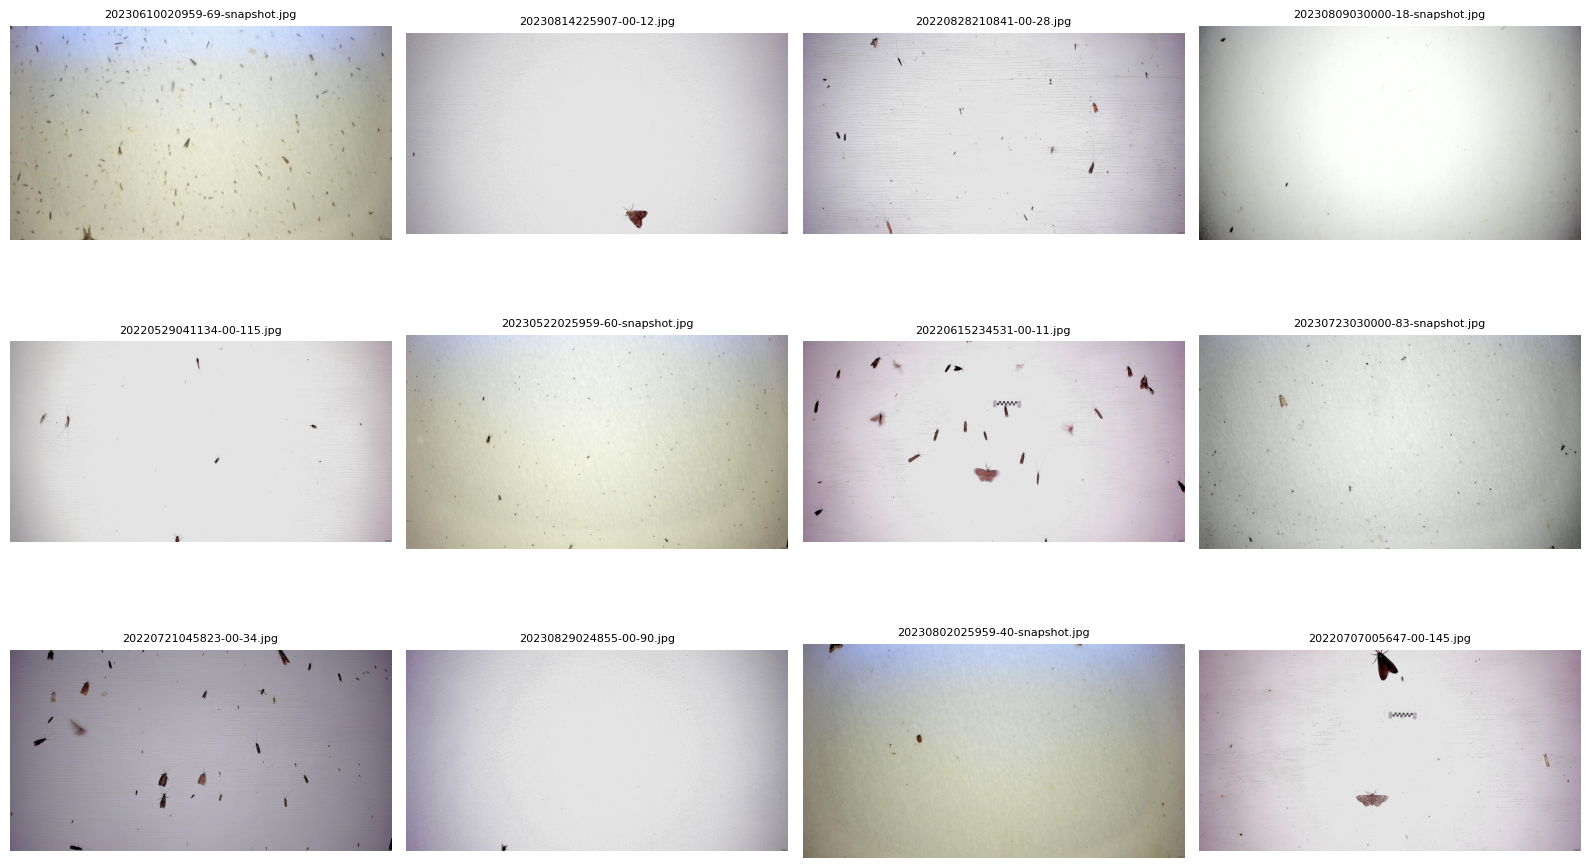

In [30]:
def show_random_images(image_list, n_rows=3, n_cols=4):
    """Display a grid of random images."""
    plt.figure(figsize=(16, 10))
    for i in range(n_rows * n_cols):
        idx = random.randint(0, len(image_list) - 1)
        img_path = image_list[idx]
        try:
            img = mpimg.imread(img_path)
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(img_path), fontsize=8)
            plt.axis("off")
        except Exception:
            continue
    plt.tight_layout()
    plt.show()

show_random_images(image_paths)

### Drawing Rectangles

../dataset/images/20-20220716220000-snapshot.jpg


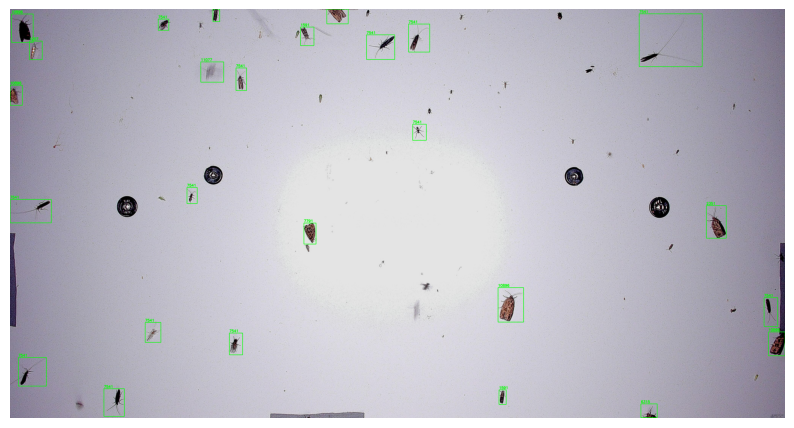

In [41]:
test_image_path = f"{images_path}/20-20220716220000-snapshot.jpg"
test_label_path = f"{labels_path}/20-20220716220000-snapshot.txt"

print(test_image_path)

# Read image using OpenCV (in BGR format)
image = cv2.imread(test_image_path)

# Get image dimensions
h, w, _ = image.shape

# Read YOLO labels (in the labels .txt files)
with open(test_label_path, "r") as f:
    lines = f.readlines()

# Draw boxes on image
for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center, y_center, bw, bh = map(float, parts[1:])

    # Convert normalized coordinates to pixel values
    x_center *= w
    y_center *= h
    bw *= w
    bh *= h

    # Get top-left and bottom-right corners
    x1 = int(x_center - bw / 2)
    y1 = int(y_center - bh / 2)
    x2 = int(x_center + bw / 2)
    y2 = int(y_center + bh / 2)

    # Draw rectangle and class ID
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, str(class_id), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (0, 255, 0), 2)

# Convert BGR to RGB (for correct color display in matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

### Structure Understanding

First, there is an **images** directory that contains all the images, each featuring one or more insects. Then, there is a **labels** directory that contains text files with **annotation data**. Each text file includes the insect’s **class id and the pixel coordinates** of its location within the corresponding image. There is one text file per image, and each text file **shares the same filename** as its associated image.

There is also another text file called **classes** which contains all the classes of insects that got detected.

Another json file is there called **note** which contains classes with their **id** and **rank**.

The image files in images directory is connected to label text files in labels directory by having the same name. Label text file connected with note json file through the class id.

## Data Preparation

### Removing Insects with NA rank

In [ ]:
## removing insects with rank 11077, 11431, 7541

### Removing Images Without Insects

In [31]:
image_extensions = [".jpg", ".png", ".jpeg"]

counter = 0

# Loop through label files
for label_file in os.listdir(labels_path):
    if not label_file.endswith(".txt"):
        continue

    label_path = os.path.join(labels_path, label_file)

    # Check if label file is empty or contains only whitespace
    if os.path.getsize(label_path) == 0 or not open(label_path).read().strip():
        base_name = os.path.splitext(label_file)[0]

        # Try to find the corresponding image
        removed_image = False
        for ext in image_extensions:
            image_path = os.path.join(images_path, base_name + ext)
            if os.path.exists(image_path):
                os.remove(image_path)
                counter += 1
                print(f"Removed image: {image_path}")
                removed_image = True
                break

        # Remove the label file itself
        os.remove(label_path)
        print(f"Removed empty label: {label_path}")

        if not removed_image:
            print(f"No matching image found for label {label_file}")

print(f"Cleanup complete: all empty label files and matching images removed ({counter} images).")

Removed image: ../dataset/images\01-20220918051959-snapshot.jpg
Removed empty label: ../dataset/labels\01-20220918051959-snapshot.txt
Removed image: ../dataset/images\01-20220928231959-snapshot.jpg
Removed empty label: ../dataset/labels\01-20220928231959-snapshot.txt
Removed image: ../dataset/images\20-20230123182000-snapshot.jpg
Removed empty label: ../dataset/labels\20-20230123182000-snapshot.txt
Removed image: ../dataset/images\20220516020405-00-132.jpg
Removed empty label: ../dataset/labels\20220516020405-00-132.txt
Removed image: ../dataset/images\20220516024813-00-143.jpg
Removed empty label: ../dataset/labels\20220516024813-00-143.txt
Removed image: ../dataset/images\20220601153521-00-01.jpg
Removed empty label: ../dataset/labels\20220601153521-00-01.txt
Removed image: ../dataset/images\20220601160332-00-07.jpg
Removed empty label: ../dataset/labels\20220601160332-00-07.txt
Removed image: ../dataset/images\20220603113828-00-01.jpg
Removed empty label: ../dataset/labels\202206031

### Spliting Dataset into train/validation/test

In [32]:
# Create folders
for split in ["train", "val", "test"]:
    os.makedirs(f"{output_path}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_path}/labels/{split}", exist_ok=True)

# Split
image_files = glob(f"{images_path}/*.jpg")  # or .png that can be add later
random.shuffle(image_files)

n = len(image_files)
train_end = int(0.7 * n)
val_end = int(0.9 * n)

splits = {
    "train": image_files[:train_end],
    "val": image_files[train_end:val_end],
    "test": image_files[val_end:]
}

# Move corresponding images and labels
for split, files in splits.items():
    for img_path in files:
        filename = os.path.basename(img_path)
        label_path = os.path.join(labels_path, filename.replace(".jpg", ".txt"))

        shutil.copy(img_path, f"{output_path}/images/{split}/{filename}")
        shutil.copy(label_path, f"{output_path}/labels/{split}/{filename.replace('.jpg', '.txt')}")

print("Data splitting done!")

Data splitting done!


### Image Count Per Section

In [33]:
def number_of_images(image_dir): 
    return len([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)])
            
print(f"For training {number_of_images(f"{output_path}/images/train")} images")
print(f"For validating {number_of_images(f"{output_path}/images/val")} images")
print(f"For testing {number_of_images(f"{output_path}/images/test")} images")

For training 1840 images
For validating 526 images
For testing 263 images
